# Train an MLP based autoencoder for MNIST data
Define the network and the bottleneck data size

1.  Bottleneck size refers to the encoded feature size
2.  Decreasing bottleneck size reduces the reconstruction quality

 You can try out different values to bottleneck size and visualize the results


 


In [0]:
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
import os


def model_def(bottleneck_size):
  input_img = Input(shape=(784,))
  encoded = Dense(512, activation='relu')(input_img)
  encoded = Dense(128, activation='relu')(encoded)
  encoded = Dense(64, activation='relu')(encoded)
  encoded = Dense(bottleneck_size, activation='linear')(encoded)
  encoder = Model(input_img, encoded)
  #define the decoder as the reverse of encoder
  encoded_input = Input(shape=(bottleneck_size,))
  decoded = Dense(64, activation='relu')(encoded_input)
  decoded = Dense(128, activation='relu')(decoded)
  decoded = Dense(512, activation='relu')(decoded)
  decoded = Dense(784, activation='sigmoid')(decoded)
  decoder = Model(encoded_input, decoded)
  # the autoencoder is a combination od both encoder and decoder
  full = decoder(encoder(input_img))
  ae = Model(input_img, full)
  ae.compile(optimizer='adam', loss='mean_squared_error')
  return encoder,decoder,ae


In [2]:
###### load the MNIST train and test data
from keras.datasets import mnist
import numpy as np
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32')  / 255.
x_train = x_train.reshape(x_train.shape[0], 784)
x_test = x_test.reshape(x_test.shape[0], 784)


########### Define the AE model with bottleneck size (4 is used here)
encoder,decoder,ae=model_def(4)


###### Train the model
ae.fit(x_train, x_train, 
        epochs = 50,
        batch_size=256,
        validation_data=(x_test, x_test))

##### Save the models if required  (uncomment)
#ae.save('AE_model.h5')
#encoder.save('Encoder_model.h5')
#decoder.save('Decoder_model.h5')


Using TensorFlow backend.


Epoch 1/50
235/235 [==============================] - 8s 33ms/step - loss: 0.0640 - val_loss: 0.0403
Epoch 2/50
235/235 [==============================] - 8s 33ms/step - loss: 0.0368 - val_loss: 0.0344
Epoch 3/50
235/235 [==============================] - 8s 33ms/step - loss: 0.0334 - val_loss: 0.0325
Epoch 4/50
235/235 [==============================] - 8s 33ms/step - loss: 0.0318 - val_loss: 0.0313
Epoch 5/50
235/235 [==============================] - 8s 33ms/step - loss: 0.0307 - val_loss: 0.0306
Epoch 6/50
235/235 [==============================] - 8s 33ms/step - loss: 0.0299 - val_loss: 0.0299
Epoch 7/50
235/235 [==============================] - 8s 33ms/step - loss: 0.0292 - val_loss: 0.0291
Epoch 8/50
235/235 [==============================] - 8s 33ms/step - loss: 0.0285 - val_loss: 0.0288
Epoch 9/50
235/235 [==============================] - 8s 33ms/step - loss: 0.0278 - val_loss: 0.0281
Epoch 10/50
235/235 [==============================] - 8s 33ms/step - loss: 0.0273 - val_lo

# Visualize the results


1.   Plot the input images and the reconstructions from the AE
2.   t-sne plots to visualize the dataset

----- t-sne plot on the input images

----- t-sne plot of the encoder embeddings

Ideally since the embeddings finds a low dimentional space for the input images. The t-sne should have well separated data points.

A good read on t-sne :

https://towardsdatascience.com/t-sne-python-example-1ded9953f26



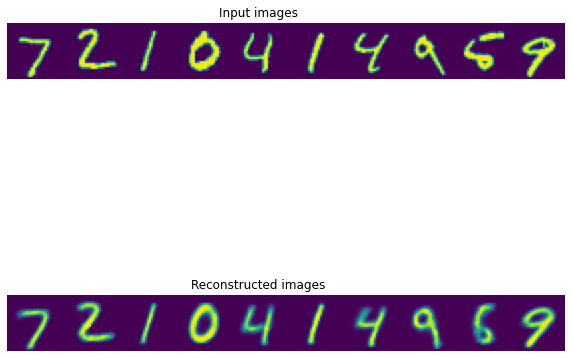

In [3]:
def visualize(x_test, decoded_imgs):
  fig, ax = plt.subplots(2, 10,gridspec_kw={'wspace':0, 'hspace':0}, figsize=(10,10))
 
  for i in range(10):    
        ax[0, i].axis('off')
        ax[0, i].imshow(x_test[i].reshape(28,28))
        ax[1, i].axis('off')
        ax[1, i].imshow(decoded_imgs[i].reshape(28,28))
  ax[0,4].set_title('Input images')
  ax[1,4].set_title('Reconstructed images')
  plt.show()      

encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)
visualize(x_test,decoded_imgs)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


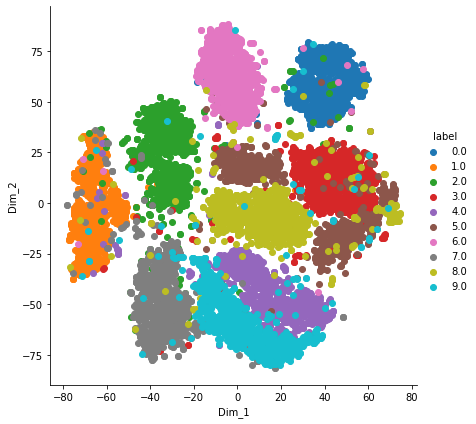

In [4]:
from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sn
model = TSNE(n_components=2, random_state=0)
tsne_data = model.fit_transform(x_test)
tsne_data = np.vstack((tsne_data.T, y_test)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


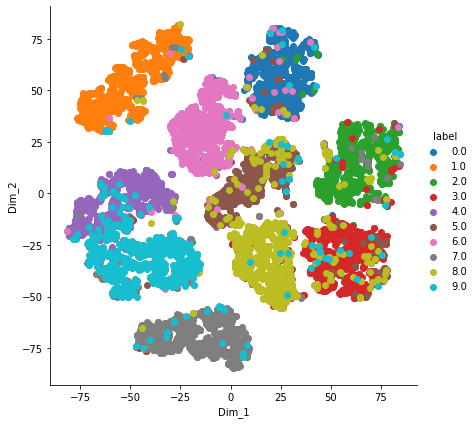

In [5]:
model = TSNE(n_components=2, random_state=0)
tsne_data = model.fit_transform(encoded_imgs)
tsne_data = np.vstack((tsne_data.T, y_test)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

# Latent Space interpolation

Check out a good read in  : https://hackernoon.com/latent-space-visualization-deep-learning-bits-2-bd09a46920df

Playing with the encoded features.


1.   First we interpolate linearly in the image space (inputinterpolation.gif). Here you can see that the transition from one image to another creates ghosty images in between.
2.   Next we interpolate in the latent space (latentsinterpolation.gif). Here the transition is much smoother.




In [10]:
#latent space interpolation
import imageio
input_images = []
latents_images=[]
randint=np.random.randint(0,len(x_test),(2))
input1=x_test[randint[0]]
input2=x_test[randint[1]]
print(encoded_imgs.shape)
alpha=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
for i in alpha:
  input3=(1-i)*input1+i*input2
  input_images.append(input3.reshape(28,28))
  encoded_imgs3=(1-i)*encoded_imgs[randint[0],:]+i*encoded_imgs[randint[1],:]
  encoded_imgs3=np.expand_dims(encoded_imgs3,0)
  decoded_imgs3 = decoder.predict(encoded_imgs3)
  latents_images.append(decoded_imgs3.reshape(28,28))
imageio.mimsave(os.path.join('inputinterpolation.gif'), input_images, duration = 0.4)
imageio.mimsave(os.path.join('latentsinterpolation.gif'), latents_images, duration = 0.4)

(10000, 4)


In [11]:
import IPython
from IPython.display import Image
Image(open('inputinterpolation.gif','rb').read(), width=160, height=160)

In [12]:
Image(open('latentsinterpolation.gif','rb').read(), width=160, height=160)